In [1]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

c:\Users\stefa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (

[{'generated_text': "Hello, I'm a language model, I'm a language model. In my mind, I'm doing the same thing as you. All these different people are thinking about the same thing.\n\nI'm not talking about what the computer program does. I'm talking about what I'm thinking about. I'm thinking about what my body is thinking about. I'm thinking about what I'm making it. I'm thinking about what I'm making it. What my body is doing. I'm thinking about what my body is thinking about. What's my body doing? What's my body doing? What's my body doing?\n\nLet's talk about this, I'm not a computer programmer. I'm not a software developer. I'm not a computer programmer. I'm not a language model. I'm not a language model. My body is thinking about what I'm doing. What is my body doing? What's my body doing? What's my body doing?\n\nNow, I'm not saying that this is a good thing. But if you want to get better at programming, you can get better at writing. You can get better at being human. You can get

Min Train Loss: 2.866975
Min Validation Loss: 3.1155
Max Hellaswag eval: 0.2934


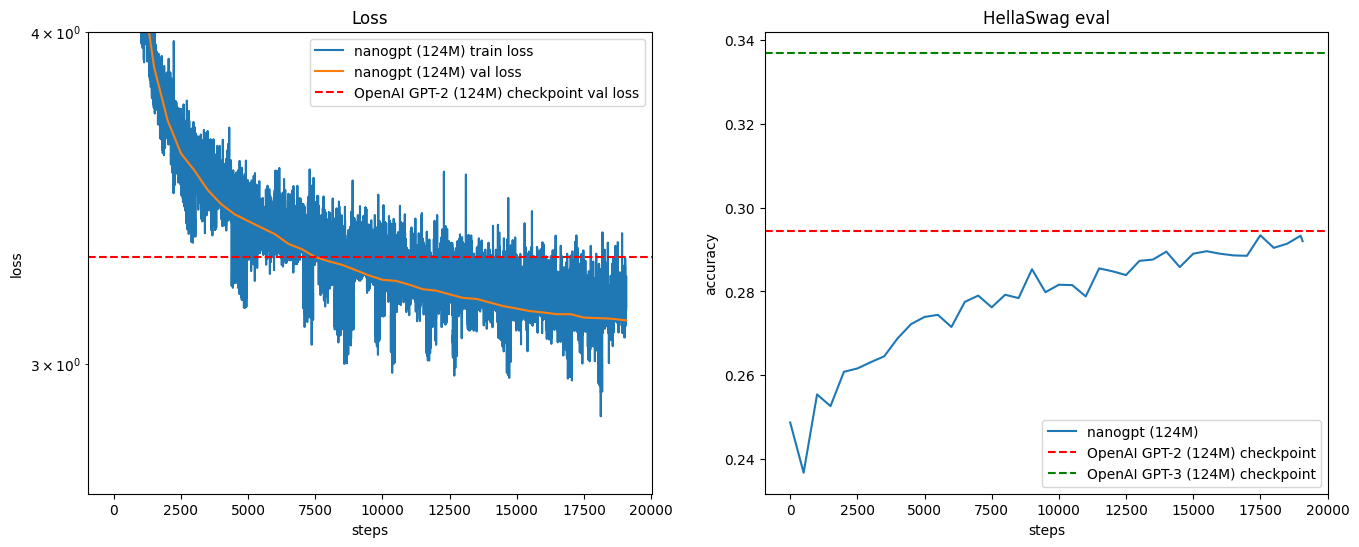

In [1]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

In [5]:
from model import GPTConfig, GPT
import torch
import torch.nn.functional as F
import tiktoken

device = "cuda" if torch.cuda.is_available() else "cpu"

model = GPT(GPTConfig(vocab_size=50304))
ckpt = torch.load("log/model_19072.pt", map_location="cpu", weights_only=False)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt


model.load_state_dict(state)
model.to(device)
enc = tiktoken.get_encoding("gpt2")


model.eval()
num_return_sequences = 4
max_length = 50
tokens = enc.encode("The Holocaust")
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to("cpu")
while xgen.size(1) < max_length:
    with torch.no_grad():
        logits, loss = model(xgen) # (B, T, vocab_size)
        logits = logits[:, -1, :] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim=1)
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"{i}: {decoded}")


0: The Holocaust, where everyone's life has become a kind of sacred memory, is becoming difficult to express. In the past few years, it's become more difficult to talk about memory with a public, so too has the Holocaust, which is a complex
1: The Holocaust and Social Studies 4 ELA 2.0 (3.0)<|endoftext|>The latest news from academia, regulators
research labs and other things of interest
Posted: May 4, 2009
Researchers in California are being encouraged by the government to
2: The Holocaust Museum
The Jewish Museum’s Holocaust Museum is located in the old Tzitzkor’t-Zion and the Jewish Quarter in the center of the historic district in Yom Tov in Israel’s eastern
3: The Holocaust has been the most talked about national issue with Holocaust History Month, this June in Washington, D.C."
The theme for this year's Yad Vashem exhibition is "The Holocaust in the Modern World." "During the Holocaust, individuals
